<a href="https://colab.research.google.com/github/Hassan-293/My-Project/blob/main/Train_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
     

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE
     

from albumentations import (Compose, OneOf, 
                            CLAHE, Flip,Rotate,Transpose,ShiftScaleRotate,IAAPiecewiseAffine,RandomRotate90,ChannelShuffle,ElasticTransform,Flip,GridDistortion,HorizontalFlip,HueSaturationValue,OpticalDistortion,
                            RandomBrightnessContrast,RandomGamma,RandomSizedCrop,VerticalFlip,RGBShift,GaussNoise )
     

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report
     

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
     

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report    

In [ ]:
train_image_dir = r'/content/drive/MyDrive/Histo Data/Train_Processed'
train_mask_dir = r'/content/drive/MyDrive/Histo Data/Labels_Processesd'
     

In [ ]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])
print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))

Number of training images :  238
Number of training masks :  238


In [ ]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [ ]:
print("After shuffling")
print(train_image_paths[0:5])
print(train_mask_paths[0:5])
# Sequence intact !

After shuffling
['/content/drive/MyDrive/Histo Data/Train_Processed/consep_14.png', '/content/drive/MyDrive/Histo Data/Train_Processed/crag_11.png', '/content/drive/MyDrive/Histo Data/Train_Processed/glas_32.png', '/content/drive/MyDrive/Histo Data/Train_Processed/crag_9.png', '/content/drive/MyDrive/Histo Data/Train_Processed/glas_16.png']
['/content/drive/MyDrive/Histo Data/Labels_Processesd/consep_14.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/crag_11.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/glas_32.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/crag_9.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/glas_16.png']


In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
from skimage.io import imread

class CustomDataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size, img_size):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Load images and masks
        x = np.zeros((len(batch_x), *self.img_size, 3))
        y = np.zeros((len(batch_y), *self.img_size, 1))
        for i, (img_file, mask_file) in enumerate(zip(batch_x, batch_y)):
            img = imread(img_file)
            img = img / 255.0  # Normalize pixel values to [0, 1]
            x[i] = img

            mask = imread(mask_file)
            mask = mask / 255.0  # Normalize pixel values to [0, 1]
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            y[i] = mask

        return x, y


In [ ]:
# Parameters
batch_size = 10
img_size = (256, 256)

# Splitting
train_image_files = train_image_paths[:190]
train_mask_files = train_mask_paths[:190]

valid_image_files = train_image_paths[190:]
valid_mask_files = train_mask_paths[190:]

# Create generators
train_gen = CustomDataGenerator(train_image_files, train_mask_files, batch_size, img_size)
valid_gen = CustomDataGenerator(valid_image_files, valid_mask_files, batch_size, img_size)


In [ ]:
import os

# Define directories for masked images and actual images
TRAIN_IMAGE_DIR = r'/content/drive/MyDrive/Histo Data/Train_Processed'
TRAIN_MASK_DIR = r'/content/drive/MyDrive/Histo Data/Labels_Processesd'

# Check if the directories exist
print(os.path.exists(TRAIN_IMAGE_DIR))
print(os.path.exists(TRAIN_MASK_DIR))

# Print out the file paths of the images
train_image_paths = [os.path.join(TRAIN_IMAGE_DIR, f) for f in os.listdir(TRAIN_IMAGE_DIR)]
print(train_image_paths)
train_mask_paths = [os.path.join(TRAIN_MASK_DIR, f) for f in os.listdir(TRAIN_MASK_DIR)]
print(train_mask_paths)


True
True
['/content/drive/MyDrive/Histo Data/Train_Processed/dpath_11.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_1.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_10.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_15.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_16.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_13.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_12.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_14.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_23.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_17.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_19.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_22.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_2.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_20.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_18.png', '

In [ ]:
def read_image(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    return img

In [ ]:
def read_mask(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    img = (img>0).astype(np.uint8)
    return img

In [ ]:
import math
class Train_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)
# Carefully selected augmentations...works fine with retina...idk abt nucleus !
  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0), 
      Rotate(always_apply = True,limit=(-360, 360), border_mode=3, p = 1.0),
      Flip(always_apply = True),
      OneOf([
             GaussNoise()
             ], p=0.9),
      OneOf([
             HorizontalFlip()
                 
      ], p=0.6),
      
      OneOf([
             
             RandomBrightnessContrast(),
             RandomGamma()
             ], p=0.2),
     OneOf([VerticalFlip()],p=0.7)
     ,
     OneOf([HueSaturationValue()],p=0.5)
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  
     


In [ ]:

class Val_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
       k=math.ceil(len(self.x) / self.batch_size)
      #  print(k)
      #  print(len(self.x))
      #  print(self.batch_size)
       return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0)
    ])


  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
      print(batch_x)
      print(batch_y)

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])
      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  
     

In [ ]:
train_generator = Train_Generator(train_image_files, train_mask_files)
valid_generator = Val_Generator(valid_image_files, valid_mask_files)
     


In [ ]:
# Finally 3 dims 
for i, j in train_generator:
  print(i.dtype)
  print(j.dtype)
  break

float64
float64


In [ ]:
image = imread('/content/drive/MyDrive/Histo Data/Super_Imposed/consep_1.png')

import numpy as np

image=np.array(image) 
print(image.shape)



(500, 500)


In [ ]:
# Finally 3 dims 
for i,j in train_generator:
  print(i.shape)
  print(j.shape)
  break

(10, 256, 256, 3)
(10, 256, 256, 3, 1)


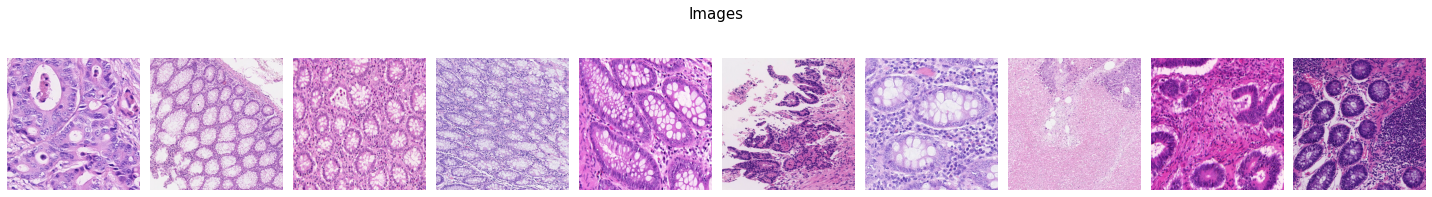

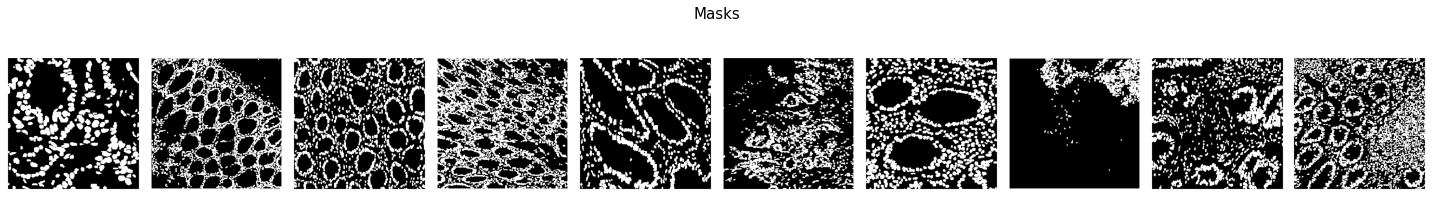

In [ ]:

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def train_generator():
  return Train_Generator(train_image_files, train_mask_files, augmentation=True).__iter__()
def valid_generator():
  return Val_Generator(valid_image_files, valid_mask_files, augmentation=True).__iter__()


ds_train = tf.data.Dataset.from_generator(
    train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([10,256,256,3], [10,256,256,3,1])
).repeat()

ds_valid = tf.data.Dataset.from_generator(
    valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([10,256,256,3], [10,256,256,3,1])
).repeat()

#(10, 256, 256, 3)
#(10, 256, 256, 3, 1)

In [ ]:
train_generator_aug = Train_Generator(train_image_files, train_mask_files,augmentation=True)

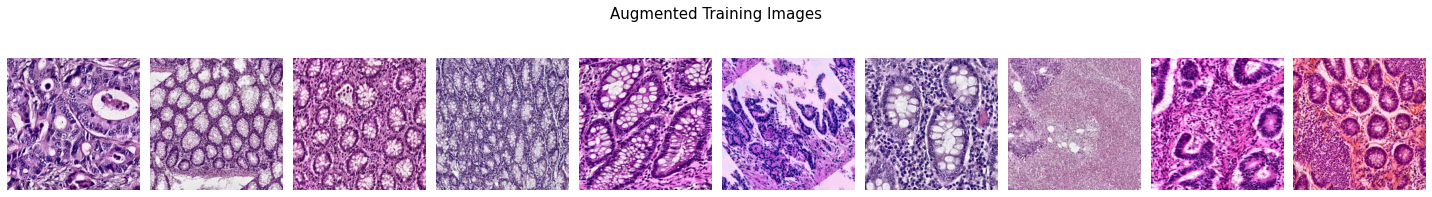

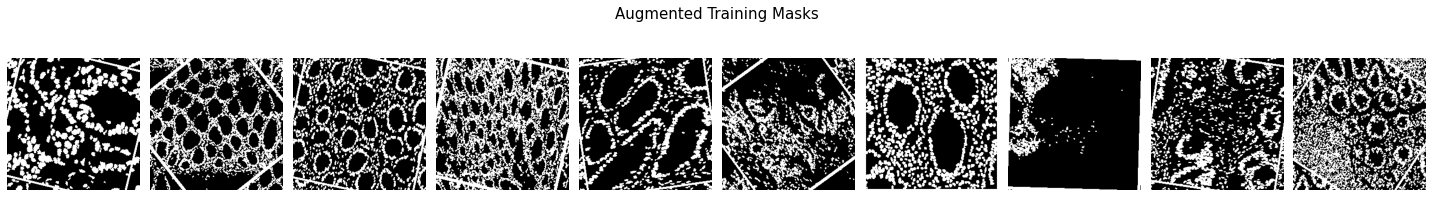

In [ ]:
# Augmented training set
for i, j in ds_train:
    break

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

['/content/drive/MyDrive/Histo Data/Train_Processed/pannuke_2.png', '/content/drive/MyDrive/Histo Data/Train_Processed/consep_16.png', '/content/drive/MyDrive/Histo Data/Train_Processed/crag_5.png', '/content/drive/MyDrive/Histo Data/Train_Processed/crag_29.png', '/content/drive/MyDrive/Histo Data/Train_Processed/glas_36.png', '/content/drive/MyDrive/Histo Data/Train_Processed/dpath_9.png', '/content/drive/MyDrive/Histo Data/Train_Processed/crag_44.png', '/content/drive/MyDrive/Histo Data/Train_Processed/pannuke_23.png', '/content/drive/MyDrive/Histo Data/Train_Processed/glas_4.png', '/content/drive/MyDrive/Histo Data/Train_Processed/glas_61.png']
['/content/drive/MyDrive/Histo Data/Labels_Processesd/pannuke_2.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/consep_16.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/crag_5.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/crag_29.png', '/content/drive/MyDrive/Histo Data/Labels_Processesd/glas_36.png', '/con

UnknownError: ignored

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = y_true * y_pred
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou(y_true, y_pred):
    thresh = 0.5
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')
    intersection = K.sum(K.minimum(y_true, y_pred)) + smooth
    union = K.sum(K.maximum(y_true, y_pred)) + smooth
    iou = intersection/union
    return iou

In [ ]:
def nested_unet():

  inputs = Input((256,256, 3))

  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0') (inputs)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0_1') (A_conv_0)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_pool_0 = MaxPooling2D((2, 2)) (A_conv_0)

  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0') (A_pool_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0_1') (B_conv_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_pool_0 = MaxPooling2D((2, 2)) (B_conv_0)

  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0') (B_pool_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0_1') (C_conv_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_pool_0 = MaxPooling2D((2, 2)) (C_conv_0)

  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0') (C_pool_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0_1') (D_conv_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_pool_0 = MaxPooling2D((2, 2)) (D_conv_0)

  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0') (D_pool_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0_1') (E_conv_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_pool_0 = MaxPooling2D((2, 2)) (E_conv_0)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_1') (B_conv_0)
  A_conv_1 = concatenate([A_conv_0, A_conv_1], name='A_concat_1')
  A_conv_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_1') (A_conv_1)
  A_conv_1 = BatchNormalization() (A_conv_1)

  B_conv_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_1') (C_conv_0)
  B_conv_1 = concatenate([B_conv_0, B_conv_1], name='B_concat_1')
  B_conv_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_1') (B_conv_1)
  B_conv_1 = BatchNormalization() (B_conv_1)

  C_conv_1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_1') (D_conv_0)
  C_conv_1 = concatenate([C_conv_0, C_conv_1], name='C_concat_1')
  C_conv_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_1') (C_conv_1)
  C_conv_1 = BatchNormalization() (C_conv_1)

  D_conv_1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='D_trans_1') (E_conv_0)
  D_conv_1 = concatenate([D_conv_0, D_conv_1], name='D_concat_1')
  D_conv_1 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_1') (D_conv_1)
  D_conv_1 = BatchNormalization() (D_conv_1)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_2') (B_conv_1)
  A_conv_2 = concatenate([A_conv_0, A_conv_1, A_conv_2], name='A_concat_2')
  A_conv_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_2') (A_conv_2)
  A_conv_2 = BatchNormalization() (A_conv_2)

  B_conv_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_2') (C_conv_1)
  B_conv_2 = concatenate([B_conv_0, B_conv_1, B_conv_2], name='B_concat_2')
  B_conv_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_2') (B_conv_2)
  B_conv_2 = BatchNormalization() (B_conv_2)

  C_conv_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_2') (D_conv_1)
  C_conv_2 = concatenate([C_conv_0, C_conv_1, C_conv_2], name='C_concat_2')
  C_conv_2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_2') (C_conv_2)
  C_conv_2 = BatchNormalization() (C_conv_2)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_3') (B_conv_2)
  A_conv_3 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3], name='A_concat_3')
  A_conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_3') (A_conv_3)
  A_conv_3 = BatchNormalization() (A_conv_3)

  B_conv_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_3') (C_conv_2)
  B_conv_3 = concatenate([B_conv_0, B_conv_1, B_conv_2, B_conv_3], name='B_concat_3')
  B_conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_3') (B_conv_3)
  B_conv_3 = BatchNormalization() (B_conv_3)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_4') (B_conv_3)
  A_conv_4 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3, A_conv_4], name='A_concat_4')
  A_conv_4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_4') (A_conv_4)
  A_conv_4 = BatchNormalization() (A_conv_4)

  #-------------------------------------------------------------------------------------------------------------#

  A_out_1 = Conv2D(1, (1, 1), activation='sigmoid',name='out1') (A_conv_1)
  A_out_2 = Conv2D(1, (1, 1), activation='sigmoid',name='out2') (A_conv_2)
  A_out_3 = Conv2D(1, (1, 1), activation='sigmoid',name='out3') (A_conv_3)
  A_out_4 = Conv2D(1, (1, 1), activation='sigmoid',name='out4') (A_conv_4)

  outputs = average([A_out_1, A_out_2, A_out_3, A_out_4])

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

model = nested_unet()
model.summary()
     

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 A_conv_0 (Conv2D)              (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 256, 256, 64  256        ['A_conv_0[0][0]']               
 ormalization)                  )                                                           

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
def lr_schedule(epoch):

    lr =0.001
    if epoch >15:
        lr *=2**-1
    elif epoch >10:
        lr *=2**(-1)
    elif epoch >8:
        lr *=2**(-1)
    elif epoch >5:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [ ]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [ ]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
# optimiser=tf.keras.optimizers.SGD(
#     learning_rate=lr_schedule(0),

# )
model.compile(optimizer =optimiser , loss = bce_dice_loss, metrics = ['accuracy', iou,'AUC'])
     

Learning rate:  0.001


In [ ]:
history = model.fit(
    ds_train, 
    steps_per_epoch=500//10,
    epochs=20,
    validation_data = ds_valid,    
    validation_steps =170//10,callbacks=callbacks
     )

Learning rate:  0.001
Epoch 1/20


ValueError: ignored

In [ ]:
from PIL import Image

# Open image file
img = Image.open("/content/drive/MyDrive/Histo Data/Labels_Processesd/consep_1.png")

# Get dimensions
width, height = img.size

# Print dimensions
print(f"Image dimensions: {width} x {height}")


Image dimensions: 256 x 256


In [ ]:
import cv2

# Load image
img = cv2.imread("/content/drive/MyDrive/Histo Data/Train_Processed/consep_1.png")

# Get dimensions
height, width, channels = img.shape

# Print dimensions
print(f"Image dimensions: {width} x {height}")


Image dimensions: 256 x 256
